In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [5]:
def create_dataset(path):

    df = pd.read_excel(path)
    df["Weekday"] = df["DateTime"].apply(lambda x: x.weekday())
    df["Weekday"] = df["Weekday"].map({0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"})
    df = pd.get_dummies(df, columns=["Weekday"], prefix='', prefix_sep='', dtype=float)
    dataset = df.drop(columns=["DateTime","ID"]).values
    return dataset


paths =["./Data/Hot_Cui_Mie.xlsx", "./Data/Pondok_Desa_Malang.xlsx", "./Data/Solaria.xlsx", "./Data/Excelso.xlsx", "./Data/Hachi_Hachi_Bistro.xlsx"]
datasets = []

for path in paths:
    datasets.append(create_dataset(path))


In [6]:
#since we have so little data only a small forecast is feasible
look_back = 6
forecast = 1

train_sets = []
test_sets = []

X_trainsets = []
Y_trainsets = []
X_testsets = []
Y_testsets = []

def train_test_split(dataset, lookback, split):
    train = dataset[:-(split + lookback),:]
    test = dataset[-(split + lookback):,:]
    return train, test

def create_timeseries(dataset,lookback,forecast):

    X = []
    Y = []

    for i in range(lookback, len(dataset) - forecast + 1):
        X.append(dataset[i - lookback: i,:])
        Y.append(dataset[i: i + forecast,0])

    X = np.array(X)
    Y = np.array(Y)
    return X,Y

for dataset in datasets:
    train, test = train_test_split(dataset,look_back,split=12)
    train_sets.append(train)
    test_sets.append(test)

for trainset in train_sets:
    X, Y = create_timeseries(trainset,look_back, forecast)
    X_trainsets.append(X)
    Y_trainsets.append(Y)

for testset in test_sets:
    X, Y = create_timeseries(testset,look_back, forecast)
    X_testsets.append(X)
    Y_testsets.append(Y)

In [7]:

models = {}
neurons = [32,64,128,256]
bidir = [True,False]

for neuron in neurons:
    for bi in bidir:
        name = f"Model_Neur{neuron}_Bi_{bi}"
        if bi == True:
            model = Sequential()
            model.add(Bidirectional(LSTM(neuron, return_sequences=True, input_shape=(look_back,train_sets[1].shape[1]), activation="relu")))
            model.add(Bidirectional(LSTM(neuron, activation="relu")))
            model.add(Dense(forecast))
            model.compile(loss="mean_squared_error", optimizer="adam")
        else:
            model = Sequential()
            model.add(LSTM(neuron, return_sequences=True, input_shape=(look_back,train_sets[1].shape[1]), activation="relu"))
            model.add(LSTM(neuron, activation="relu"))
            model.add(Dense(forecast))
            model.compile(loss="mean_squared_error", optimizer="adam")
        models[name] = model




In [8]:
for key in models:
    for m in range(25):
        for i, _ in enumerate(X_trainsets):
            models[key].fit(X_trainsets[i], Y_trainsets[i], epochs=1, batch_size=8, verbose=0)
    print(f"{key} is done")


Model_Neur32_Bi_True is done
Model_Neur32_Bi_False is done
Model_Neur64_Bi_True is done
Model_Neur64_Bi_False is done
Model_Neur128_Bi_True is done
Model_Neur128_Bi_False is done
Model_Neur256_Bi_True is done
Model_Neur256_Bi_False is done


In [16]:
loss_sums = {}


for key in models:
    print(f"-----{key} evaluation-----")
    sum = 0
    for i, _ in enumerate(X_testsets):
        loss = models[key].evaluate(X_testsets[i], Y_testsets[i], batch_size=8, verbose=1)
        sum += loss
    loss_sums[key] = sum
    print(f"Sum over all Testsets: {sum}")



-----Model_Neur32_Bi_True evaluation-----
2/2 [==============================] - 0s 5ms/step - loss: 0.0278
Sum over all Testsets: 0.12710773386061192
-----Model_Neur32_Bi_False evaluation-----
2/2 [==============================] - 0s 5ms/step - loss: 0.0295
Sum over all Testsets: 0.14392139576375484
-----Model_Neur64_Bi_True evaluation-----
2/2 [==============================] - 0s 5ms/step - loss: 0.0257
Sum over all Testsets: 0.1323563437908888
-----Model_Neur64_Bi_False evaluation-----
2/2 [==============================] - 0s 4ms/step - loss: 0.0229
Sum over all Testsets: 0.12321300990879536
-----Model_Neur128_Bi_True evaluation-----
2/2 [==============================] - 0s 6ms/step - loss: 0.0264
Sum over all Testsets: 0.15172767266631126
-----Model_Neur128_Bi_False evaluation-----
2/2 [==============================] - 0s 4ms/step - loss: 0.0184
Sum over all Testsets: 0.11482623219490051
-----Model_Neur256_Bi_True evaluation-----
2/2 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 22ms/step


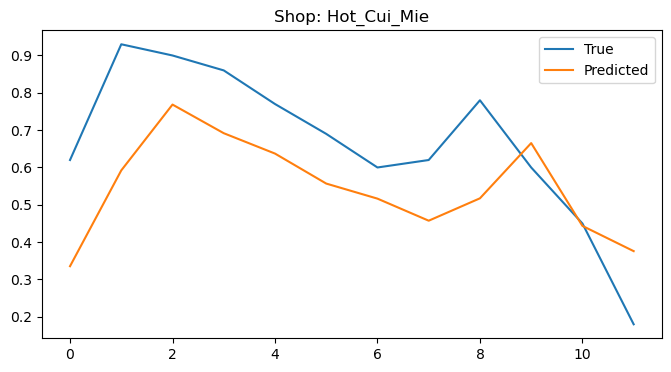

1/1 [==============================] - 0s 18ms/step


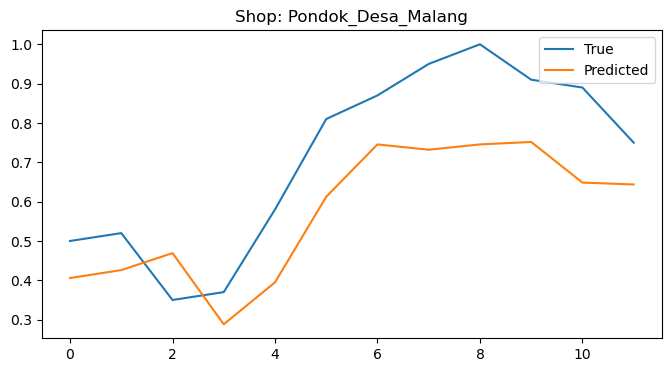

1/1 [==============================] - 0s 18ms/step


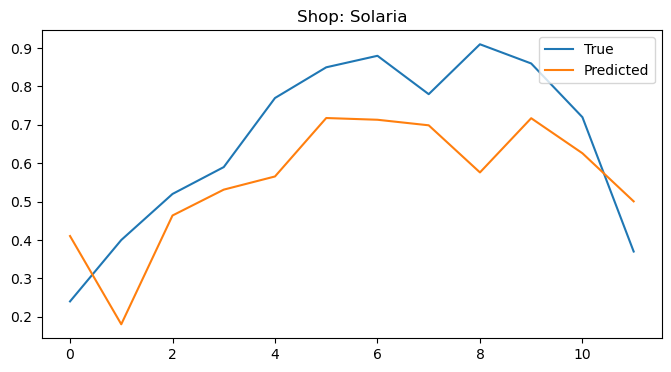

1/1 [==============================] - 0s 17ms/step


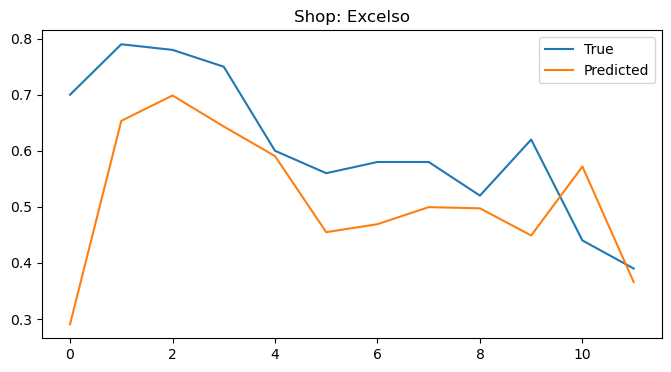

1/1 [==============================] - 0s 19ms/step


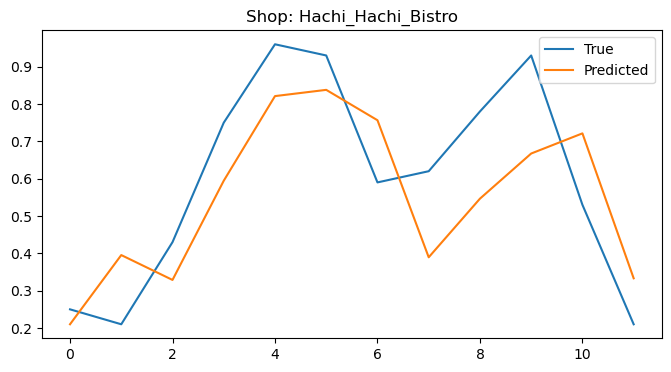

In [17]:
shops =["Hot_Cui_Mie", "Pondok_Desa_Malang", "Solaria", "Excelso", "Hachi_Hachi_Bistro"]

for i, _ in enumerate(X_testsets):
    y_true = Y_testsets[i].reshape(-1,1)
    y_pred = models["Model_Neur32_Bi_False"].predict(X_testsets[i])
    plt.figure(figsize=(8,4))
    plt.title(f"Shop: {shops[i]}")
    plt.plot(y_true, label="True")
    plt.plot(y_pred, label="Predicted")
    leg = plt.legend(loc='upper right')
    plt.show()


In [18]:
filename = "bestmodel.pkl"
pickle.dump(models["Model_Neur128_Bi_False"], open(filename, 'wb'))

filename = "second_bestmodel.pkl"
pickle.dump(models["Model_Neur64_Bi_False"], open(filename, 'wb'))

#needed since predict data will not always have every weekday in the data
df = pd.read_excel(path)
df["Weekday"] = df["DateTime"].apply(lambda x: x.weekday())
df["Weekday"] = df["Weekday"].map({0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"})
df = pd.get_dummies(df, columns=["Weekday"], prefix="", prefix_sep="", dtype=float)
df = df.drop(columns=["DateTime","ID"])

filename = "model_columns.pkl"
pickle.dump(df.columns, open(filename, 'wb'))